In [9]:
# Imports
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import torch as torch
from torch import nn
from nltk.tokenize import word_tokenize
import math as mt
import time
import random
from joblib import Parallel, delayed
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle
import helper
print("Done")

Done


# Task 2.1: Classifier on Hindi Data

In [10]:
# Reading Hindi Data

if torch.cuda.is_available():
    device = "cuda:0"
    dev = "cuda:0"
else:
    device = "cpu"
    dev = "cpu"
    
url = 'data/hindi_hatespeech.tsv'
data = pd.read_csv(url, sep='\t')
    
data_development = shuffle(data)
labels = data_development['task_2']
type(data_development['task_1'])

print("Done", device)

Done cuda:0


In [11]:
#Removing stop words
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences)
print('Total words:', len(non_unique))
print('Unique words:', len(V))

embedding_size = 640

Number of sentences:  4665
Total words: 141550
Unique words: 19836


In [12]:
#Load Word2Vec Hindi embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_hindi', device, len(V), embedding_size)
#weights1 contain the trained embedding weights from task1

print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=19836, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=19836, bias=True)
)
torch.Size([19837, 640]) torch.Size([640, 19836])


### Create Dataset

In [13]:
## create number array of sentences (replace each word with each numeric value)
x_data, max_len_curr = helper.sentence_to_numeric_arr(sentences, V)

## apply padding
padded = np.array(helper.padding(x_data, max_len_curr))

print("Padded Data Shape: ", padded.shape)
encoded_labels = [0 if label == "NONE" else 1 for label in labels]
encoded_labels = np.array(encoded_labels)
print("Encoded Labels Shape: ",encoded_labels.shape)

Padded Data Shape:  (4665, 132)
Encoded Labels Shape:  (4665,)


In [14]:
#split data into train & test set
batch_size = 64
train_loader, test_loader = helper.split_data_train_valid_test(padded, encoded_labels, batch_size)
print("Done")

Done


## Training Hindi Classfier

<ipython-input-15-9228b31dd9b6>:24: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/80 Training Loss: 0.6851
Epoch: 2/80 Training Loss: 0.6396
Epoch: 3/80 Training Loss: 0.5659
Epoch: 4/80 Training Loss: 0.4809
Epoch: 5/80 Training Loss: 0.4221
Epoch: 6/80 Training Loss: 0.3585
Epoch: 7/80 Training Loss: 0.3038
Epoch: 8/80 Training Loss: 0.2496
Epoch: 9/80 Training Loss: 0.2120
Epoch: 10/80 Training Loss: 0.1820
Epoch: 11/80 Training Loss: 0.1540
Epoch: 12/80 Training Loss: 0.1251
Epoch: 13/80 Training Loss: 0.1104
Epoch: 14/80 Training Loss: 0.0915
Epoch: 15/80 Training Loss: 0.0929
Epoch: 16/80 Training Loss: 0.0766
Epoch: 17/80 Training Loss: 0.0715
Epoch: 18/80 Training Loss: 0.0687
Epoch: 19/80 Training Loss: 0.0642
Epoch: 20/80 Training Loss: 0.0540
Epoch: 21/80 Training Loss: 0.0632
Epoch: 22/80 Training Loss: 0.0491
Epoch: 23/80 Training Loss: 0.0428
Epoch: 24/80 Training Loss: 0.0373
Epoch: 25/80 Training Loss: 0.0438
Epoch: 26/80 Training Loss: 0.0341
Epoch: 27/80 Training Loss: 0.0320
Epoch: 28/80 Training Loss: 0.0385
Epoch: 29/80 Training Loss: 0

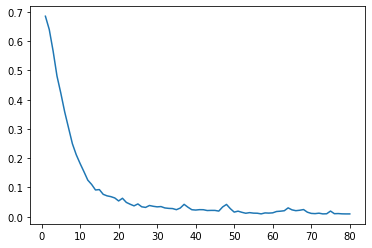

In [15]:
# Initialize LSTM Model
net, criterion= helper.initialize_SentimentLSTM_model(len(V) + 1, embedding_size, 32, 1, 2, device, weights1)

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, amsgrad=True)
print_every = 100
step = 0
n_epochs = 80
clip = 5

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_hindi.png')
print("Done")

## Testing Hindi Classifier

In [12]:
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.7563
Test Accuracy: 0.71


# Task 2.2: Testing Bengali Data on Hindi Classifier (Transfer Learning)

In [16]:
#Reading Bengali data
bengali_data, labels = helper.get_bengali_data('data/bengali_hatespeech.csv')
# print(bengali_data)
print(bengali_data.shape, labels.shape)

## Stopwords Removal of Bengali Data
bengali_sentences = helper.apply_stopword_removal(bengali_data)
print("Number of sentences: " , len(bengali_sentences))

## Building Vocabulary
bengali_V, bengali_non_unique = helper.build_vocabulary(bengali_sentences)
print('Total words:', len(bengali_non_unique))
print('Unique words:', len(bengali_V))

## Sentence to numeric array
x_data_bengali, max_len_curr = helper.sentence_to_numeric_arr(bengali_sentences, bengali_V)

## Apply Padding
padded = np.array(helper.padding(x_data_bengali, max_len_curr))

## Splitting data into train and test
train_loader, test_loader = helper.split_data_train_valid_test(padded, labels, 64)

print("Done")

(4665, 3) (4665,)
Number of sentences:  4665
Total words: 64027
Unique words: 14482
Done


### Training Classifier on Bengali data with trained Hindi embeddings (Transfer Learning)

<ipython-input-16-66faedab04df>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/20 Training Loss: 0.6856
Epoch: 2/20 Training Loss: 0.4768
Epoch: 3/20 Training Loss: 0.2224
Epoch: 4/20 Training Loss: 0.1052
Epoch: 5/20 Training Loss: 0.0654
Epoch: 6/20 Training Loss: 0.0454
Epoch: 7/20 Training Loss: 0.0296
Epoch: 8/20 Training Loss: 0.0278
Epoch: 9/20 Training Loss: 0.0226
Epoch: 10/20 Training Loss: 0.0231
Epoch: 11/20 Training Loss: 0.0257
Epoch: 12/20 Training Loss: 0.0147
Epoch: 13/20 Training Loss: 0.0105
Epoch: 14/20 Training Loss: 0.0099
Epoch: 15/20 Training Loss: 0.0061
Epoch: 16/20 Training Loss: 0.0061
Epoch: 17/20 Training Loss: 0.0068
Epoch: 18/20 Training Loss: 0.0048
Epoch: 19/20 Training Loss: 0.0055
Epoch: 20/20 Training Loss: 0.0039
Done


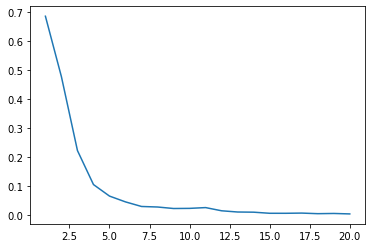

In [16]:
net, criterion= helper.initialize_SentimentLSTM_model_bengali(len(V) + 1, embedding_size, 32, 1, 2, device, weights1)

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, amsgrad=True)
n_epochs = 20
clip = 5

training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_transferlearning.png')    
print("Done")

### Testing Classifier

In [17]:
net.eval()

test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.4164
Test Accuracy: 0.75


# Task 2.3: Training classifier on Bengali embeddings

In [17]:
#Reading Bengali Data
bengali_data = pd.read_csv('data/bengali_hatespeech.csv')

bengali_data_hate = bengali_data.loc[bengali_data['hate'] == 1]
bengali_data_not_hate = bengali_data.loc[bengali_data['hate'] == 0]

bengali_data_hate = bengali_data_hate.iloc[0:2332] 
bengali_data_not_hate = bengali_data_not_hate.iloc[0:2333]

data_development = pd.concat([bengali_data_hate, bengali_data_not_hate])
data_development = shuffle(data_development)
data_development.columns = ["text", "hate", "category"]

labels = data_development['hate']
labels = np.array(labels)

#Removing stop words
sentences = helper.apply_stopword_removal(data_development)
print("Number of sentences: " , len(sentences))

#Building Vocabulary
V, non_unique = helper.build_vocabulary(sentences)
print('Total words:', len(non_unique))
print('Unique words:', len(V))

Number of sentences:  4665
Total words: 64027
Unique words: 14482


In [19]:
# Hyperparameters
window_size = 4
embedding_size = 640
learning_rate = 0.01
epochs =1

In [20]:
# Create model 

class Word2Vec(nn.Module):
    def __init__(self, features, embedding_size):
        super().__init__()
        self.fc1 = nn.Linear(features, embedding_size)
        self.fc2 = nn.Linear(embedding_size, features)


    def forward(self, one_hot):
        x = self.fc1(one_hot.float())
        x = self.fc2(x)
        log_softmax = torch.nn.functional.log_softmax(x, dim=1)
        return log_softmax

print("Done")

Done


In [ ]:
#Creating target, context tuple
x_train, y_train = helper.create_dataset(sentences, non_unique, V, window_size)
print(x_train.shape)

In [21]:
x_train = np.load('x_train_bengali.npy')
y_train = np.load('y_train_bengali.npy')

In [22]:
batch_size = 1000
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_train = data_utils.TensorDataset(x_train, y_train)
train_dl = DataLoader(x_train, batch_size=batch_size, shuffle=True)
features = len(V)
total_rows = len(y_train)
print(total_rows)

442454


### Training Bengali Embeddings

Started:


<ipython-input-15-d75c1c675acc>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])


Epoch: 0 	Loss: 8.06457371701111
Epoch: 1 	Loss: 7.097379783214068
Epoch: 2 	Loss: 6.841117040086164
Epoch: 3 	Loss: 6.7123113698046035
Epoch: 4 	Loss: 6.622108471154635
Epoch: 5 	Loss: 6.556159672599062
Epoch: 6 	Loss: 6.503734928462447
Epoch: 7 	Loss: 6.467378518629181
Epoch: 8 	Loss: 6.440557552074271
Epoch: 9 	Loss: 6.416795361015473
Epoch: 10 	Loss: 6.393877284298496
Epoch: 11 	Loss: 6.370895241310443
Epoch: 12 	Loss: 6.349754609615606
Epoch: 13 	Loss: 6.336859772093843
Epoch: 14 	Loss: 6.32120620753027
Epoch: 15 	Loss: 6.302735242652468
Epoch: 16 	Loss: 6.292469624687143
Epoch: 17 	Loss: 6.281074477197864
Epoch: 18 	Loss: 6.26736055663009
Epoch: 19 	Loss: 6.256652884069158
Epoch: 20 	Loss: 6.2483494255218845
Epoch: 21 	Loss: 6.240326163497959
Epoch: 22 	Loss: 6.229096388232734
Epoch: 23 	Loss: 6.219747252347474
Epoch: 24 	Loss: 6.211229831975924
Epoch: 25 	Loss: 6.207000768529811
Epoch: 26 	Loss: 6.201535836625471
Epoch: 27 	Loss: 6.194525578505212
Epoch: 28 	Loss: 6.186886371111

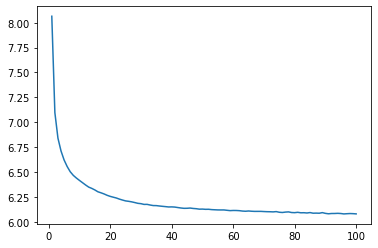

In [23]:
# Define optimizer and loss
net = Word2Vec(len(V), embedding_size)
net.to(dev)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()

def train():
    print("Started:")
    loss_vals=  []
    for e in range(epochs):
        epoch_loss= []
        for i, (X_batch, y_batch) in enumerate(train_dl):
            X_batch = np.eye(len(V))[X_batch]
            y_batch = np.eye(len(V))[y_batch]
            X_batch = torch.Tensor(X_batch).to(dev)
            y_batch = torch.Tensor(y_batch).to(dev)
            y_pred_torch = net(X_batch)
            loss = criterion(y_pred_torch, torch.max(torch.tensor(y_batch), 1)[1])
            optimizer.zero_grad()
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print('Epoch:', e,'\tLoss:',loss_vals[e])
#         break
    plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
    plt.savefig('Task1_benali.png')
    torch.save(net.state_dict(), 'model_param_bengali_temp')
train()

print("Training finished")

In [12]:
#Load Word2Vec embeddings module
weights1, weights2 = helper.load_word2vec_embeddings('model_param_bengali', device, len(bengali_V), embedding_size)
#weights1 contain the trained embedding weights from task1
print(weights1.shape, weights2.shape)

Word2Vec(
  (fc1): Linear(in_features=14482, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=14482, bias=True)
)
torch.Size([14483, 640]) torch.Size([640, 14482])


### Training Classifier

<ipython-input-24-67b170ed25d8>:23: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(net.parameters(), clip)


Epoch: 1/30 Training Loss: 0.6930
Epoch: 2/30 Training Loss: 0.6671
Epoch: 3/30 Training Loss: 0.5985
Epoch: 4/30 Training Loss: 0.5194
Epoch: 5/30 Training Loss: 0.4552
Epoch: 6/30 Training Loss: 0.4153
Epoch: 7/30 Training Loss: 0.3673
Epoch: 8/30 Training Loss: 0.3184
Epoch: 9/30 Training Loss: 0.2733
Epoch: 10/30 Training Loss: 0.2336
Epoch: 11/30 Training Loss: 0.2108
Epoch: 12/30 Training Loss: 0.1895
Epoch: 13/30 Training Loss: 0.1757
Epoch: 14/30 Training Loss: 0.1628
Epoch: 15/30 Training Loss: 0.1282
Epoch: 16/30 Training Loss: 0.1196
Epoch: 17/30 Training Loss: 0.1142
Epoch: 18/30 Training Loss: 0.1006
Epoch: 19/30 Training Loss: 0.1010
Epoch: 20/30 Training Loss: 0.0818
Epoch: 21/30 Training Loss: 0.0694
Epoch: 22/30 Training Loss: 0.0808
Epoch: 23/30 Training Loss: 0.0750
Epoch: 24/30 Training Loss: 0.0719
Epoch: 25/30 Training Loss: 0.0583
Epoch: 26/30 Training Loss: 0.0746
Epoch: 27/30 Training Loss: 0.0597
Epoch: 28/30 Training Loss: 0.0562
Epoch: 29/30 Training Loss: 0

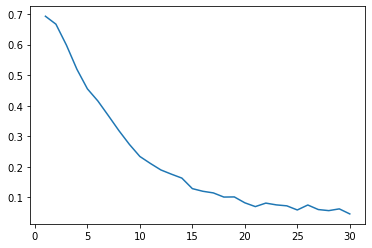

In [24]:
net, criterion = helper.initialize_SentimentLSTM_model(len(bengali_V) + 1, embedding_size, 32, 1, 2, device, weights1)

optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, amsgrad=True)
print_every = 100
step = 0
n_epochs = 30
clip = 5


training_loss_epoches = []
for epoch in range(n_epochs):
    h = net.init_hidden(batch_size, device)
    training_loss = []
    for i, (inputs, labels) in enumerate(train_loader):
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        h = tuple([each.data for each in h])   
        
        net.zero_grad()
        output, h = net(inputs, batch_size)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        training_loss.append(loss.item())
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
    training_loss_epoches.append(np.mean(training_loss))
    print("Epoch: {}/{}".format((epoch+1), n_epochs),
          "Training Loss: {:.4f}".format(np.mean(training_loss)))
plt.plot(np.linspace(1, len(training_loss_epoches), len(training_loss_epoches)).astype(int), training_loss_epoches)
plt.savefig('Task2_bengali.png')   
print("Done")

### Testing Classifier

In [25]:
net.eval()
test_losses = []
num_correct = 0
test_h = net.init_hidden(batch_size, device)

for i, (inputs, labels) in enumerate(test_loader):
    test_h = tuple([each.data for each in test_h])
    try:
        test_output, test_h = net(inputs.to(device), batch_size)
    except IndexError:
        print(inputs)
#     print(labels.dtype, test_output.dtype)
#     print(inputs)
    loss = criterion(test_output.detach().to(device), labels.float().to(device))
    test_losses.append(loss.item())
    
    preds = torch.round(test_output.squeeze())
    
    
    correct_tensor = preds.eq(labels.float().view_as(preds).to(device))
    correct = np.squeeze(correct_tensor.cpu().detach().numpy())
    num_correct += np.sum(correct)
    
print("Test Loss: {:.4f}".format(np.mean(test_losses)))
print("Test Accuracy: {:.2f}".format(num_correct/len(test_loader.dataset)))

Test Loss: 1.2797
Test Accuracy: 0.73


## Hyperopt Implementation
### Note: Hyperopt was used for the selection of the model.

In [ ]:
def train_hyperopt(space)
    learning_rate = space['learning_rate']
    n_epochs = space['epochs']
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, amsgrad=True)
    clip = 5  # for gradient clip to prevent exploding gradient problem in LSTM/RNN
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'


    training_loss_epoches = []
    for epoch in range(n_epochs):
        h = net.init_hidden(batch_size, device)
        training_loss = []
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            h = tuple([each.data for each in h])
            net.zero_grad()
            output, h = net(inputs, batch_size)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            training_loss.append(loss.item())
            nn.utils.clip_grad_norm(net.parameters(), clip)
            optimizer.step()
            
    net.eval()
    valid_losses = []
    v_h = net.init_hidden(batch_size, device)

    for v_inputs, v_labels in valid_loader:
        v_inputs, v_labels = inputs.to(device), labels.to(device)

        v_h = tuple([each.data for each in v_h])

        v_output, v_h = net(v_inputs, batch_size)
        v_loss = criterion(v_output.squeeze(), v_labels.float())
        valid_losses.append(v_loss.item())
        
        np.mean(valid_losses)
        return {'loss': np.mean(valid_losses), 'model': net, 'status': STATUS_OK}

space = {
        'learning_rate': hp.quniform('learning_rate', 0.001, 0.04, 0.005),
        'epochs': hp.quniform('epochs', 20, 200, 20),
        'train': train_loader,
        'y_train': y_train.to_numpy(),
        'val': val_loader}

    trials = Trials()
    best = fmin(fn=train_hyperopt,
                space=space,
                algo=tpe.suggest,
                max_evals=int(max_evals),
                trials=trials)